# 3. Entrenamiento y Evaluación de Modelos

**Objetivo:** Entrenar y comparar múltiples algoritmos de clasificación para seleccionar el modelo con el mejor rendimiento para nuestro problema de diagnóstico diferencial. Utilizaremos validación cruzada rigurosa y manejaremos el desbalance de clases identificado en el EDA.

## 3.1. Carga de Datos Procesados y Librerías

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# --- INICIO: Celda de configuración para guardado --- 
# 1. Crear carpetas para los reportes
FIGS_PATH = "../reports/figures/models"
METRICS_PATH = "../reports/metrics"
os.makedirs(FIGS_PATH, exist_ok=True)
os.makedirs(METRICS_PATH, exist_ok=True)

# 2. Inicializar contadores
nuevos_graficos = 0
graficos_omitidos = 0
nuevas_tablas = 0
tablas_omitidas = 0

print(f"Directorios listos en: {FIGS_PATH} y {METRICS_PATH}")
print("Contadores inicializados.")

# Librerías de Modelado
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Manejo de Desbalance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Evaluación
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, cohen_kappa_score

# Rutas
PROCESSED_DATA_DIR = "../data/processed/"
MODELS_DIR = "../models/"

# Cargar datos
X_train = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'X_train.csv'))
X_test = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'X_test.csv'))
y_train = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'y_train.csv')).values.ravel()
y_test = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'y_test.csv')).values.ravel()

print('Datos cargados:')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

Directorios listos en: ../reports/figures/models y ../reports/metrics
Contadores inicializados.
Datos cargados:
X_train: (16000, 54)
y_train: (16000,)
X_test: (4000, 54)
y_test: (4000,)


## 3.2. Definición de Modelos y Pipeline con SMOTE

Para cada clasificador, crearemos un pipeline de `imbalanced-learn`. Este pipeline primero aplicará SMOTE para sobremuestrear las clases minoritarias y luego entrenará el clasificador. Esto se hace de forma segura dentro de cada pliegue de la validación cruzada para evitar la fuga de datos.

In [5]:
# Definir los modelos base
models = {
    'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'SVM': SVC(probability=True, random_state=42) # probability=True es necesario para VotingClassifier y AUC
}

# Crear un pipeline con SMOTE para cada modelo
pipelines = {
    name: ImbPipeline(steps=[('smote', SMOTE(random_state=42)), ('classifier', model)]) 
    for name, model in models.items()
}

# Añadir un modelo de ensamble (Voting Classifier)
clf1 = models['Logistic Regression']
clf2 = models['Random Forest']
clf3 = models['XGBoost']
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)], voting='soft')
pipelines['Ensemble (Voting)'] = ImbPipeline(steps=[('smote', SMOTE(random_state=42)), ('classifier', eclf1)])

print("Pipelines de modelos creados:")
print(list(pipelines.keys()))

Pipelines de modelos creados:
['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'Ensemble (Voting)']


c:\Users\marks\Documents\PROGRAMA _TESIS\proyecto_cdss_huancayo\venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


## 3.3. Evaluación con Validación Cruzada

Utilizaremos `StratifiedKFold` con 10 pliegues para evaluar el rendimiento de cada pipeline. Mediremos múltiples métricas para obtener una visión completa del rendimiento de cada modelo.

In [7]:
# Configurar la validación cruzada
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Métricas a evaluar
scoring_metrics = ['accuracy', 'balanced_accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr']

results = {}

for name, pipeline in pipelines.items():
    print(f'Evaluando {name}...')
    # Realizar validación cruzada
    cv_results = cross_validate(pipeline, X_train, y_train, cv=kfold, scoring=scoring_metrics, n_jobs=-1)
    results[name] = {metric: cv_results[f'test_{metric}'] for metric in scoring_metrics}
    print(f"{name} - Balanced Accuracy: {np.mean(cv_results['test_balanced_accuracy']):.4f} +/- {np.std(cv_results['test_balanced_accuracy']):.4f}")
    print("\nEvaluación completada.")

Evaluando Logistic Regression...
Logistic Regression - Balanced Accuracy: 0.9997 +/- 0.0003

Evaluación completada.
Evaluando Random Forest...
Random Forest - Balanced Accuracy: 0.9999 +/- 0.0002

Evaluación completada.
Evaluando XGBoost...


c:\Users\marks\Documents\PROGRAMA _TESIS\proyecto_cdss_huancayo\venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBoost - Balanced Accuracy: 0.9998 +/- 0.0003

Evaluación completada.
Evaluando SVM...
SVM - Balanced Accuracy: 0.9997 +/- 0.0004

Evaluación completada.
Evaluando Ensemble (Voting)...


c:\Users\marks\Documents\PROGRAMA _TESIS\proyecto_cdss_huancayo\venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Ensemble (Voting) - Balanced Accuracy: 0.9999 +/- 0.0003

Evaluación completada.


## 3.4. Visualización y Guardado de Resultados de CV

In [8]:
# Crear y guardar un DataFrame resumen con las medias (solo métricas disponibles)
summary_data = {}
for name, res in results.items():
    summary_data[name] = {}
    for metric in scoring_metrics:
        if metric in res:
            summary_data[name][f'mean_{metric}'] = np.mean(res[metric])

results_df = pd.DataFrame(summary_data).T

# Guardar tabla resumen
path_tabla_summary = os.path.join(METRICS_PATH, 'cv_results_summary.csv')
if not os.path.exists(path_tabla_summary):
    if 'mean_balanced_accuracy' in results_df.columns:
        results_df.sort_values(by='mean_balanced_accuracy', ascending=False).to_csv(path_tabla_summary)
    else:
        results_df.to_csv(path_tabla_summary)
    print(f'✅ Tabla de resumen guardada en {path_tabla_summary}')
    nuevas_tablas += 1
else:
    print(f'⏭️ Archivo {path_tabla_summary} ya existe, omitiendo...')
    tablas_omitidas += 1

# Mostrar resumen ordenado si es posible
if 'mean_balanced_accuracy' in results_df.columns:
    display(results_df.sort_values(by='mean_balanced_accuracy', ascending=False))
else:
    print("⚠️ La métrica 'mean_balanced_accuracy' no está disponible en los resultados.")
    display(results_df)

⏭️ Archivo ../reports/metrics\cv_results_summary.csv ya existe, omitiendo...


,mean_accuracy,mean_balanced_accuracy,mean_f1_weighted,mean_precision_weighted,mean_recall_weighted,mean_roc_auc_ovr
Random Forest,0.999938,0.999935,0.999937,0.999938,0.999938,1.000000
Ensemble (Voting),0.999875,0.999870,0.999875,0.999875,0.999875,1.000000
XGBoost,0.999813,0.999814,0.999812,0.999813,0.999813,0.999999
Logistic Regression,0.999750,0.999740,0.999750,0.999751,0.999750,1.000000
SVM,0.999687,0.999674,0.999687,0.999688,0.999687,1.000000


⏭️ Archivo ../reports/figures/models\model_comparison_boxplot.png ya existe, omitiendo...


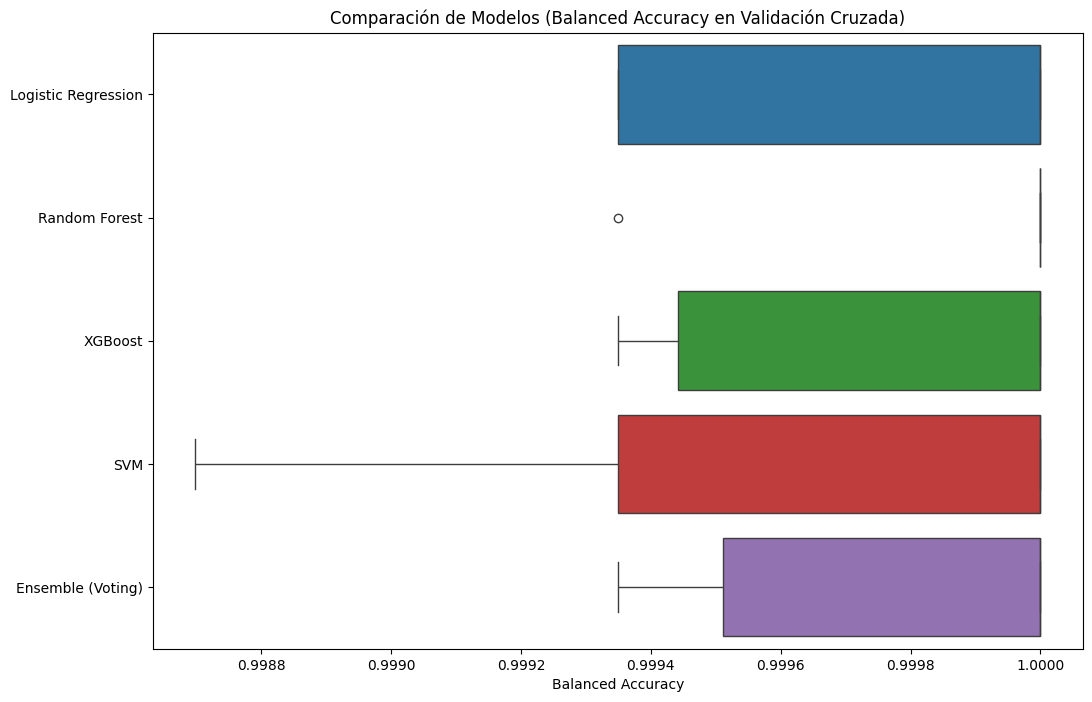

In [6]:
balanced_accuracy_scores = {name: res['balanced_accuracy'] for name, res in results.items()}
plt.figure(figsize=(12, 8))
sns.boxplot(data=pd.DataFrame(balanced_accuracy_scores), orient='h')
plt.title('Comparación de Modelos (Balanced Accuracy en Validación Cruzada)')
plt.xlabel('Balanced Accuracy')

path_figura = os.path.join(FIGS_PATH, 'model_comparison_boxplot.png')
if not os.path.exists(path_figura):
    plt.savefig(path_figura, dpi=300, bbox_inches='tight')
    print(f'✅ Gráfico guardado en {path_figura}')
    nuevos_graficos += 1
else:
    print(f'⏭️ Archivo {path_figura} ya existe, omitiendo...')
    graficos_omitidos += 1
plt.show()

## 3.5. Selección y Entrenamiento del Modelo Final

In [9]:
final_model_pipeline = pipelines['XGBoost']
final_model_pipeline.fit(X_train, y_train)
print("Modelo final (XGBoost con SMOTE) entrenado con todos los datos de entrenamiento.")

Modelo final (XGBoost con SMOTE) entrenado con todos los datos de entrenamiento.


## 3.6. Evaluación Final en el Conjunto de Prueba (Test Set)

In [10]:
y_pred = final_model_pipeline.predict(X_test)
target_names = ['DM2', 'EDA', 'HTA', 'IRA']

# Generar reporte como diccionario y guardarlo
report_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
path_tabla = os.path.join(METRICS_PATH, 'classification_report_test.csv')
if not os.path.exists(path_tabla):
    report_df.to_csv(path_tabla, index=True)
    print(f'✅ Tabla de reporte de clasificación guardada en {path_tabla}')
    nuevas_tablas += 1
else:
    print(f'⏭️ Archivo {path_tabla} ya existe, omitiendo...')
    tablas_omitidas += 1

# Imprimir el reporte para visualización
print(classification_report(y_test, y_pred, target_names=target_names))

⏭️ Archivo ../reports/metrics\classification_report_test.csv ya existe, omitiendo...
              precision    recall  f1-score   support

         DM2       1.00      1.00      1.00       960
         EDA       1.00      1.00      1.00       720
         HTA       1.00      1.00      1.00      1120
         IRA       1.00      1.00      1.00      1200

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



⏭️ Archivo ../reports/metrics\confusion_matrix_test.csv ya existe, omitiendo...
⏭️ Archivo ../reports/figures/models\confusion_matrix_test.png ya existe, omitiendo...


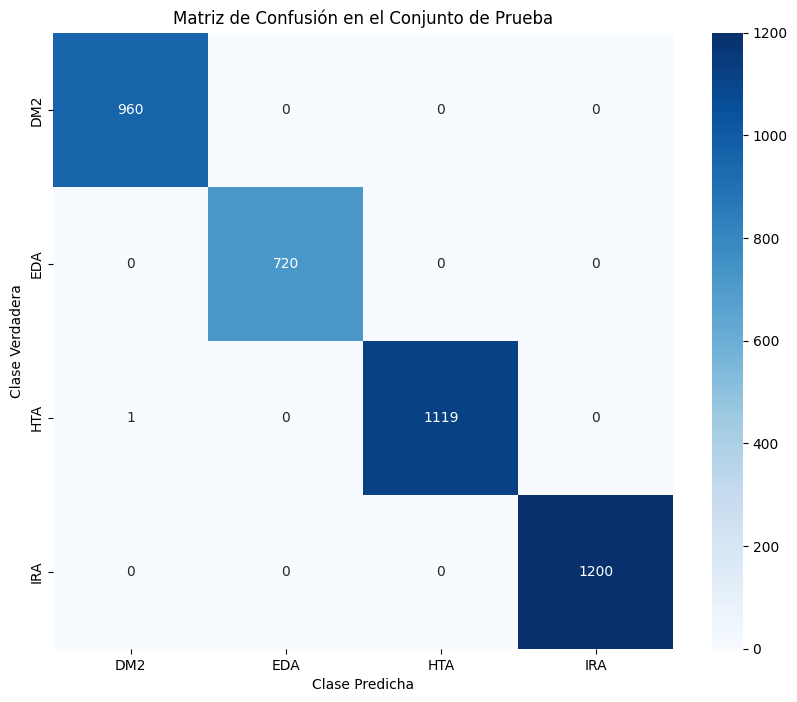

In [11]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['DM2', 'EDA', 'HTA', 'IRA'], columns=['DM2', 'EDA', 'HTA', 'IRA'])

# Guardar la tabla de la matriz de confusión
path_tabla = os.path.join(METRICS_PATH, 'confusion_matrix_test.csv')
if not os.path.exists(path_tabla):
    cm_df.to_csv(path_tabla)
    print(f'✅ Tabla de matriz de confusión guardada en {path_tabla}')
    nuevas_tablas += 1
else:
    print(f'⏭️ Archivo {path_tabla} ya existe, omitiendo...')
    tablas_omitidas += 1

# Visualizar el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión en el Conjunto de Prueba')
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')

# Guardar la figura del heatmap
path_figura = os.path.join(FIGS_PATH, 'confusion_matrix_test.png')
if not os.path.exists(path_figura):
    plt.savefig(path_figura, dpi=300, bbox_inches='tight')
    print(f'✅ Gráfico de matriz de confusión guardado en {path_figura}')
    nuevos_graficos += 1
else:
    print(f'⏭️ Archivo {path_figura} ya existe, omitiendo...')
    graficos_omitidos += 1

plt.show()

## 3.7. Guardado del Modelo Final

In [12]:
os.makedirs(MODELS_DIR, exist_ok=True)
path_modelo = os.path.join(MODELS_DIR, 'final_model.pkl')
joblib.dump(final_model_pipeline, path_modelo)
print(f"Modelo final guardado en {path_modelo}")

Modelo final guardado en ../models/final_model.pkl


In [13]:
# --- Resumen Final del Proceso ---
print("\n" + "*" * 50)
print("PROCESO DE GUARDADO COMPLETADO EN 03_Modeling.ipynb")
print("*" * 50)
print(f"✅ Gráficos nuevos guardados: {nuevos_graficos}")
print(f"⏭️ Gráficos omitidos (ya existían): {graficos_omitidos}")
print(f"✅ Tablas nuevas guardadas: {nuevas_tablas}")
print(f"⏭️ Tablas omitidas (ya existían): {tablas_omitidas}")
print("*" * 50)


**************************************************
PROCESO DE GUARDADO COMPLETADO EN 03_Modeling.ipynb
**************************************************
✅ Gráficos nuevos guardados: 0
⏭️ Gráficos omitidos (ya existían): 1
✅ Tablas nuevas guardadas: 0
⏭️ Tablas omitidas (ya existían): 3
**************************************************
